In [1]:
from erlyx.environment import BaseEnvironment, Episode, GymEnvironment
from erlyx import types

import numpy as np

import cv2

In [2]:
from datetime import datetime

In [3]:
from erlyx.policies import PytorchPolicy, FeedForwardNetworkPolicy, Policy
from erlyx.agents import EpsilonGreedyAgent, BaseAgent
from erlyx.datasets import DequeDataset, BaseDataset
from erlyx.algorithms.ddqn import DoubleDeepQLearner
from erlyx.callbacks import *

import erlyx

import torch

In [4]:
from collections import deque

In [5]:
from time import sleep

In [6]:
class BWGymEnvironment(GymEnvironment):
    IMG_HW = (105, 80)
    
    def __init__(self, env_name, repeat=4, simplified_reward=True):
        super(BWGymEnvironment, self).__init__(env_name)
        self._repeat = repeat
        self._simplified_reward = simplified_reward
        
    def new_episode(self) -> (Episode, types.ObservationType):
        observation = self.gym_env.reset()
        return self, self._resize_bw(observation)
    
    def _resize_bw(self, observation):
        return cv2.resize(cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY), (self.IMG_HW[1], self.IMG_HW[0]))
    
    def step(self, action):
        reward = 0
        for _ in range(self._repeat):
            observation, _reward, done, _ = self.gym_env.step(action)
            reward += _reward
            #self.gym_env.render()
            #sleep(1/65)
        if self._simplified_reward:
            if reward > 0:
                reward = 1
            elif reward < 0:
                reward = -1
            else:
                reward = 0
        return types.EpisodeStatus(self._resize_bw(observation), reward, done)

In [7]:
class TransitionHistoryDataset(BaseDataset):
    def __init__(self, input_shape, max_length, history_length=4):
        self._states = np.zeros(shape=(max_length, *input_shape), dtype=np.uint8)
        self._actions = np.zeros(shape=max_length, dtype=np.uint8)
        self._rewards = np.zeros(shape=max_length, dtype=np.int8)
        self._dones = np.zeros(shape=max_length, dtype=np.uint8)
        self._position = 0
        self._max_length = max_length
        self._history_length = history_length
        self._rng = np.random.default_rng()
        
    def push(self, transition):
        state, action, next_state, reward, done = transition
        next_position = (self._position + 1) % self._max_length
        self._states[[self._position, next_position], :] = [state, next_state]
        self._actions[self._position] = action
        self._rewards[self._position] = reward
        self._dones[next_position] = done
        self._position = next_position

    def __getitem__(self, index):
        if self._dones[index]:
            return self[index+1]
        indexes  = np.arange(index - self._history_length + 1, index + 2) % self._max_length
        transition_slice = self._states[indexes, :]
        # Transforma los estados anteriores que tengan done=True en ceros
        previous_done_index = np.insert(self._dones[indexes[:-2]], 0, 0).cumsum().argmax()
        transition_slice[:previous_done_index, :] = 0
        # builds transition
        state = transition_slice[:self._history_length]
        next_state = transition_slice[1:self._history_length+1]
        action = self._actions[index]
        reward = self._rewards[index]
        done = self._dones[indexes[-1]]
        if state.shape[0] != 4:
            raise Exception
        return (state, action, next_state, reward, done)
    
    def sample(self, batch_size):
        return [self[index] for index in self._rng.choice(self._max_length, batch_size)]

In [8]:
class ConvNetwork(torch.nn.Module):
    def __init__(self):
        print('original')
        super(ConvNetwork, self).__init__()
        self._conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(4, 32, kernel_size=8, stride=4),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size=3, stride=1),
            torch.nn.ReLU(),
        )
        self._linear = torch.nn.Sequential(
            torch.nn.Linear(64*70, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512,  num_actions)
        )
                
    def forward(self, x):
        #if x.shape[1] != 4:
        #    raise Exception
        if len(x.shape) == 3:
            x = x.unsqueeze(0)
        output = self._conv1(x)
        output = output.view(x.shape[0], -1)
        output = self._linear(output)
        return output

In [9]:
class CNNPolicy(PytorchPolicy):
    def __init__(self):
        self._model = ConvNetwork()
        
    @property
    def model(self):
        return self._model
    
    def process_observation(self, observation):
        tensor = torch.Tensor(observation/128. - 1.)/0.35 # divided by 0.35 because of standard deviation
        return tensor
        
    def get_distribution(self, state):
        with torch.no_grad():
            self.model.eval()
            q_values = self.model(self.process_observation(state))
            distribution = torch.nn.functional.softmax(q_values, dim=1)
        return distribution.data.cpu().numpy().reshape(-1)
    
    def num_actions(self) -> int:
        return num_actions


In [10]:
cp = torch.load('best_checkpoint_viernes3.sd')

In [11]:
class EpsilonGreedyHistoryAgent(BaseAgent):
    def __init__(self, policy: Policy, epsilon, obs_shape):
        super(EpsilonGreedyHistoryAgent, self).__init__(policy=policy)
        self.epsilon = epsilon
        self._obs_shape = obs_shape
        self._memory_buffer = deque(maxlen=4)
        
    def reset_memory(self):
        self._memory_buffer = deque([np.zeros(shape=self._obs_shape)]*4, maxlen=4)
        
    def select_action(self, observation: types.ObservationType) -> types.ActionType:
        self._memory_buffer.append(observation)
        if np.random.uniform() < self.epsilon:
            return np.random.choice(self.action_space)
        observation = np.asarray(list(self._memory_buffer))
        distribution = self.policy.get_distribution(observation)
        return np.argmax(distribution)

In [12]:
class AgentMemoryReseter(BaseCallback):
    def __init__(self, agent):
        self._agent = agent
        
    def on_episode_begin(self, initial_observation):
        self._agent.reset_memory()

In [13]:
num_actions = 18
policy = CNNPolicy()
policy.model.load_state_dict(cp['model'])
dataset = TransitionHistoryDataset(input_shape=(105, 80), max_length=1_000_000, history_length=4)
agent = EpsilonGreedyHistoryAgent(policy=policy, epsilon=0., obs_shape=(105, 80))
learner = DoubleDeepQLearner(32, policy, 1e-4/4, 30_000, loss_func=torch.nn.SmoothL1Loss())
learner.optimizer.load_state_dict(cp['optimizer'])

original


In [14]:
len(agent._memory_buffer)

0

In [15]:
class CheckPointer(BaseCallback):
    def __init__(self, agent, environment, learner):
        self._agent = agent
        self._environment = environment
        self._learner = learner
        self._counter = 0
        self._stats = [-float('inf'), None]
        self._evaluate = True
        self._filepath = 'cp_log.txt'
        
    def on_step_end(self, action, observation, reward, done):
        self._counter += 1
        if self._counter % 25_000 == 0:
            self._evaluate = True
        if self._counter < 1_000_000:
            self._evaluate = False
            
    def on_episode_end(self):
        if self._evaluate:
            self._evaluate = False
            reward_recorder = RewardRecorder()
            original_epsilon = self._agent.epsilon
            self._agent.epsilon = 0.01
            erlyx.run_episodes(
                self._environment, 
                self._agent, 
                5, 
                [reward_recorder], 
                use_tqdm=False
            )
            self._agent.epsilon = original_epsilon
            new_mean = np.mean(reward_recorder.rewards)
            self._checkpoint('latest_checkpoint.sd')
            if new_mean > self._stats[0]:
                print('new best wachin!')
                self._stats[0] = new_mean
                self._stats[1] = reward_recorder.rewards
                self._checkpoint('best_checkpoint.sd')
            
            with open(self._filepath, 'a') as file:
                file.write(datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
                file.write('\n')
                file.write(f'new mean: {new_mean} ({reward_recorder.rewards})')
                file.write('\n')
                file.write(f'best mean: {self._stats[0]} ({self._stats[1]})')
                file.write('\n')
            print(f'[Evaluation] mean: {new_mean}, rewards: {reward_recorder.rewards}')
            
    
    def _checkpoint(self, path):
        state = {
            'model': self._agent.policy.model.state_dict(), 
            'optimizer': self._learner.optimizer.state_dict()
        }
        torch.save(state, path)

In [16]:
class QValueTracker(BaseCallback):
    def __init__(self, policy, initial_state = None):
        self._policy = policy
        self.record = []
        self.initial_state = initial_state

    def on_episode_begin(self, initial_observation):
        if self.initial_state is None:
            self.initial_state = self._policy.process_observation(initial_observation)

    def on_step_end(self, action, observation, reward, done):
        with torch.no_grad():
            self._policy.model.eval()
            self.record.append(self._policy.model(self.initial_state))
            
    def plot(self, action):
        plt.plot(np.asarray(list(map(lambda x: x.data.cpu().numpy()[0], self.record)))[:, action])

In [17]:
train_callbacks = [
    AgentMemoryReseter(agent=agent),
    TransitionRecorder(dataset), 
    OnlineUpdater(learner, dataset, 1_000_000, 1),
    LinearEpsilonDecay(agent, 1., 0.1, 1e-6),
    RewardRecorder(),
    #QValueTracker(policy, initial_state=None),
    CheckPointer(agent, BWGymEnvironment('Seaquest-v0', simplified_reward=False), learner)
]

/home/schouhy/anaconda3/envs/rl/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [ ]:
erlyx.run_steps(BWGymEnvironment('Seaquest-v0'), agent, 12_000_000, train_callbacks)

new best wachin!
[Evaluation] mean: 4220.0, rewards: [5250.0, 2440.0, 5710.0, 4010.0, 3690.0]
new best wachin!
[Evaluation] mean: 5324.0, rewards: [3240.0, 7030.0, 2980.0, 8470.0, 4900.0]
new best wachin!
[Evaluation] mean: 6736.0, rewards: [5100.0, 9460.0, 9210.0, 6130.0, 3780.0]
[Evaluation] mean: 5942.0, rewards: [3800.0, 3970.0, 5270.0, 11100.0, 5570.0]
new best wachin!
[Evaluation] mean: 9098.0, rewards: [7310.0, 14190.0, 4540.0, 6630.0, 12820.0]
new best wachin!
[Evaluation] mean: 12934.0, rewards: [7750.0, 18330.0, 10850.0, 9070.0, 18670.0]
[Evaluation] mean: 9792.0, rewards: [12860.0, 7870.0, 14850.0, 9280.0, 4100.0]
[Evaluation] mean: 9214.0, rewards: [8980.0, 7240.0, 11070.0, 12070.0, 6710.0]
[Evaluation] mean: 7458.0, rewards: [8510.0, 7960.0, 9420.0, 4540.0, 6860.0]
[Evaluation] mean: 10574.0, rewards: [6500.0, 8480.0, 19530.0, 12120.0, 6240.0]
[Evaluation] mean: 8388.0, rewards: [7730.0, 8060.0, 9470.0, 9680.0, 7000.0]
[Evaluation] mean: 6926.0, rewards: [4990.0, 9190.0, 2

In [47]:
env = BWGymEnvironment('Seaquest-v0', repeat=4, simplified_reward=False)
rr = RewardRecorder()
erlyx.run_episodes(env, agent, 200, [AgentMemoryReseter(agent), rr])

In [26]:
import pandas as pd

In [51]:
pd.Series(rr.rewards).describe()

count      200.000000
mean      8560.350000
std       3094.868403
min       3000.000000
25%       6487.500000
50%       8300.000000
75%      10680.000000
max      17650.000000
dtype: float64

In [48]:
np.mean(rr.rewards)

8560.35

In [22]:
import matplotlib.pyplot as plt

In [23]:
import pandas as pd

In [27]:
train_callbacks

[AgentMemoryReseter,
 TransitionRecorder,
 OnlineUpdater,
 LinearEpsilonDecay,
 RewardRecorder,
 CheckPointer]

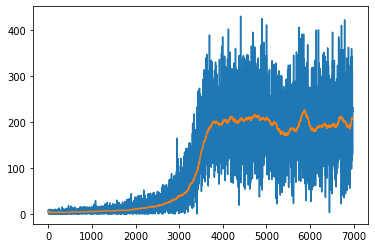

In [29]:
train_callbacks[-2].plot_rewards()
pd.Series(train_callbacks[-2].rewards).ewm(alpha=0.01).mean().plot()

In [ ]:
train_callbacks[-2].plot(0)

In [ ]:
len(dataset._memory)

In [ ]:
train_callbacks

In [ ]:
train_callbacks[-1].record[0].tolist()[0]

In [ ]:
sasa = list(map(lambda x: x.tolist()[0], train_callbacks[-1].record))

In [ ]:
sasa[

In [ ]:
pd.Series(sasa).plot()